<a href="https://colab.research.google.com/github/ludehsar/learn-fastai/blob/main/Lesson_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastai

# Image Classification Problems

## Step 1: Download images of birds and non-birds

In [2]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = "https://duckduckgo.com/"
    res = urlread(url, data={'q': term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(), {'next': 1}
    while len(urls) < max_images and 'next' in data:
        data = urljson(requestUrl, data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)

    return L(urls)[:max_images]

In [3]:
urls = search_images('bird', max_images=1)
urls[0]

'https://www.mississippiriverdelta.org/files/2015/12/BUFH-wing-feathers.jpg'

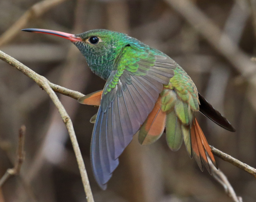

In [4]:
from fastdownload import download_url

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

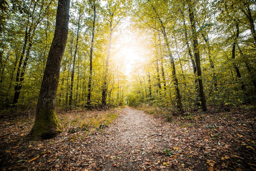

In [5]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [6]:
searches = 'forest', 'bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our Model

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we need `DataLoaders`.

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

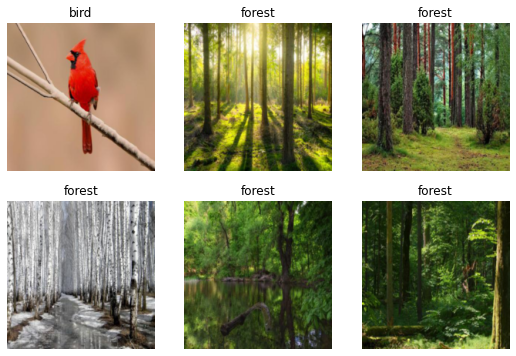

In [9]:
dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.641354,0.955401,0.280000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.096425,0.029526,0.000000,00:02
1,0.066569,0.000396,0.000000,00:01
2,0.046107,0.000113,0.000000,00:01


In [11]:
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a : {is_bird}")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a : bird
Probability it's a bird: 1.0000


# Segmentation Problems

In [12]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames=get_image_files(path/"images"),
    label_func=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes=np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The cur

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,time
0,3.437626,2.168889,00:01


epoch,train_loss,valid_loss,time
0,1.720307,1.422425,00:01
1,1.504027,1.380305,00:01
2,1.346775,1.125880,00:01
3,1.274426,1.046609,00:01
4,1.165430,0.828826,00:01
5,1.062200,0.756361,00:01
6,0.975868,0.722856,00:01
7,0.909162,0.719349,00:01


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


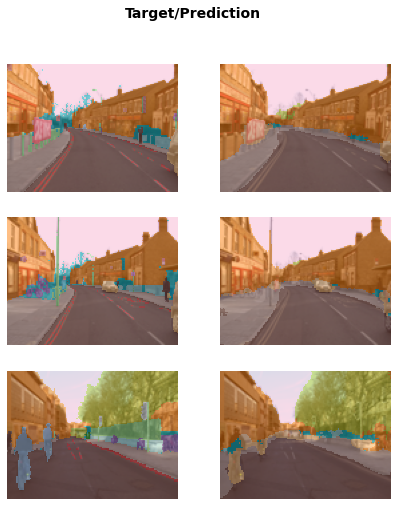

In [13]:
learn.show_results(max_n=3, figsize=(7,8))

# Tabular Analysis - Income Prediction

In [14]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names='salary',
                                  cat_names=['workclass', 'education', 'marital-status', 'occupation', 'relationship'],
                                  cont_names=['age', 'fnlwgt', 'education-num'],
                                  procs=[Categorify, FillMissing, Normalize])

In [15]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,education-num_na,age,fnlwgt,education-num,salary
0,Private,Some-college,Married-civ-spouse,Handlers-cleaners,Husband,False,29.000000,280617.997332,10.0,<50k
1,Self-emp-not-inc,Bachelors,Never-married,Sales,Own-child,False,39.000000,315639.997434,13.0,<50k
2,Private,HS-grad,Divorced,Exec-managerial,Not-in-family,False,61.000000,26254.003429,9.0,<50k
3,Private,Masters,Married-civ-spouse,Prof-specialty,Wife,False,29.000000,162550.999044,14.0,>=50k
4,Private,Bachelors,Married-civ-spouse,Adm-clerical,Husband,False,33.000000,154981.001197,13.0,>=50k
5,Self-emp-inc,Some-college,Married-civ-spouse,Exec-managerial,Husband,False,41.000000,151089.000708,10.0,>=50k
6,Self-emp-not-inc,12th,Married-civ-spouse,Sales,Wife,False,31.000000,162550.999044,8.0,<50k
7,Private,Some-college,Separated,Adm-clerical,Not-in-family,False,40.000000,190122.000019,10.0,<50k
8,Private,Masters,Married-civ-spouse,Exec-managerial,Husband,False,38.000000,169104.000450,14.0,>=50k
9,Private,Some-college,Married-civ-spouse,Tech-support,Husband,False,53.999999,215990.000600,10.0,>=50k


In [16]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.369703,0.364675,0.834459,00:07
1,0.361919,0.344735,0.843059,00:04


# Collaborative filtering -- Recommendation system

In [17]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')

In [18]:
dls.show_batch()

,userId,movieId,rating
0,624,2997,4.0
1,150,6539,4.0
2,78,1089,1.0
3,213,260,5.0
4,294,780,4.5
5,608,3578,4.0
6,481,2762,4.5
7,518,500,4.0
8,17,4993,4.5
9,574,4993,4.0


In [19]:
learn = collab_learner(dls, y_range=(0.5, 5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.518754,1.386649,00:00


epoch,train_loss,valid_loss,time
0,1.373422,1.328817,00:00
1,1.290778,1.153747,00:00
2,1.040409,0.848451,00:00
3,0.811476,0.696795,00:00
4,0.701479,0.660462,00:00
5,0.644107,0.648263,00:00
6,0.632764,0.642910,00:00
7,0.623638,0.639617,00:00
8,0.616365,0.639028,00:00
9,0.602377,0.638934,00:00


In [20]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,4.0,86.0,4.0,3.992284
1,13.0,14.0,5.0,4.333027
2,71.0,86.0,4.0,4.110816
3,80.0,76.0,3.0,3.613331
4,87.0,29.0,5.0,4.423893
5,100.0,38.0,4.0,4.293316
6,16.0,42.0,3.0,3.550232
7,60.0,57.0,4.5,4.819444
8,72.0,48.0,3.0,3.263764
